# CINIC-10 Deep Learning: MLP vs CNN Comparison

## Project: Tool Classification with Deep Neural Networks

### Introduction

Welcome to the comprehensive walkthrough for comparing Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) architectures on the CINIC-10 dataset. This notebook follows a structured approach to help you understand both the technical implementation and mathematical foundations of deep learning.

**Project Structure:**
- `src/models/`: Contains MLP and CNN model implementations
- `src/data/`: Data loading, preprocessing, and Google Drive integration
- `src/training/`: Training loops, evaluation, and comparison utilities
- `src/utils/`: Model export for deployment
- `src/api/`: FastAPI backend for production deployment

**Dataset: CINIC-10**
- **Classes**: 10 categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- **Images**: 270,000 total images (32×32 RGB)
- **Challenge**: Can deep neural networks automatically classify these tool categories?

### Learning Objectives

By the end of this notebook, you will:
1. Understand the mathematical foundations of MLPs and CNNs
2. Implement and train both architectures from scratch
3. Compare their performance and efficiency
4. Export models for production deployment
5. Analyze why CNNs are better suited for image classification

> **Note**: Execute cells using **Shift + Enter**. Follow the instructions in order and complete all marked sections.

---
## 🚀 Step 0: Environment Setup

First, let's set up our environment and verify everything is working correctly.

In [1]:
!pip install -r requirements.txt

Ignoring ml_dtypes: markers 'python_version >= "3.12"' don't match your environment
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 114.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 177.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 33.1 MB/s  0:00:10m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 40.5 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.4 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.4 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Import and run automatic environment setup
from src.utils.setup import setup_env

# This function automatically downloads the dataset if not present
# and sets up the entire environment (similar to landmark identifier)
print("🚀 Running automatic environment setup...")
setup_info = setup_env()

# Extract setup information
device = setup_info['device']
config = setup_info['config']

print("\n✅ Environment setup complete!")
print(f"📱 Device: {device}")
print(f"🎲 Seed: {setup_info['seed']}")
print(f"🔥 CUDA: {setup_info['cuda_available']}")

# Verify setup
from src.utils.setup import verify_setup
if verify_setup():
    print("\n🎯 Ready to start training!")
else:
    print("\n⚠️ Setup verification failed. Please check dataset.")

🚀 Running automatic environment setup...
🚀 Setting up CINIC-10 environment...
✅ GPU available
📋 Configuration loaded from: /home/ec2-user/SageMaker/vision-tools/configs/config.yaml
🎲 Random seed set to: 42
✅ Dataset already downloaded and organized
📊 Dataset information:
   Classes: 10
   Train: 90,000 images
   Test: 90,000 images
   Valid: 90,000 images
📁 Created directories: checkpoints, exported_models, evaluation_results, plots, logs
✅ Environment setup complete!

✅ Environment setup complete!
📱 Device: cuda
🎲 Seed: 42
🔥 CUDA: True
✅ Environment verification passed

🎯 Ready to start training!


In [17]:
# Import our data modules
from src.data.dataset import CINIC10DataModule
from src.utils.setup import get_data_location

print("📁 Setting up data pipeline...")

# The dataset should already be downloaded by setup_env()
# Let's verify and get the data location
try:
    data_location = get_data_location()
    print(f"✅ Dataset found at: {data_location}")
    
    # Use the data location from config or detected location
    data_dir = config.get('dataset', {}).get('data_dir', data_location)
    
except IOError as e:
    print(f"❌ Dataset not found: {e}")
    print("🔄 The setup_env() function should have downloaded it automatically.")
    print("📥 If download failed, please check your internet connection and Google Drive link.")
    
    # Use default path for demonstration
    data_dir = "./data/cinic10"
    
print(f"📂 Using data directory: {data_dir}")

📁 Setting up data pipeline...
✅ Dataset found at: ./data/cinic10
📂 Using data directory: ./data/cinic10


---
## 📊 Step 1: Data Setup and Exploration

Let's set up our data pipeline and explore the CINIC-10 dataset.

In [18]:
# Initialize data module
data_module = CINIC10DataModule(
    data_dir=data_dir,
    batch_size=config['data_loader']['batch_size'],
    num_workers=config['data_loader']['num_workers'],
    pin_memory=True,
    validation_split=0.2,
    seed=config['seed']
)

print("🔄 Setting up data loaders...")

# This will compute dataset statistics and create data loaders
try:
    data_loaders = data_module.setup_data_loaders(use_augmentation=True)
    
    # Display dataset information
    dataset_info = data_module.get_dataset_info()
    print("\n📊 Dataset Setup Complete:")
    print(f"   Dataset: {dataset_info['name']}")
    print(f"   Classes: {dataset_info['num_classes']}")
    print(f"   Image shape: {dataset_info['image_shape']}")
    print(f"   Batch size: {dataset_info.get('batch_size', 'N/A')}")
    
    if 'mean' in dataset_info and dataset_info['mean']:
        print(f"   Dataset mean: {[f'{x:.3f}' for x in dataset_info['mean']]}")
        print(f"   Dataset std: {[f'{x:.3f}' for x in dataset_info['std']]}")
    
    if 'train_samples' in dataset_info:
        print(f"   Train samples: {dataset_info['train_samples']:,}")
        print(f"   Validation samples: {dataset_info['val_samples']:,}")
        print(f"   Test samples: {dataset_info['test_samples']:,}")
    
    print(f"\n🎯 Class names: {dataset_info['class_names']}")
    
    # Verify data loaders work
    train_batch = next(iter(data_loaders['train']))
    print(f"\n🔍 Sample batch shape: {train_batch[0].shape}")
    print("✅ Data loaders ready for training!")
    
except Exception as e:
    print(f"⚠️ Could not load dataset: {str(e)}")
    print("🔧 This might happen if:")
    print("   1. Dataset download failed")
    print("   2. Dataset is not properly organized")
    print("   3. Insufficient disk space")
    print("\n💡 Try running setup_env(force_download=True) to re-download")
    
    # Set data_loaders to None for graceful handling
    data_loaders = None

🔄 Setting up data loaders...

📊 Dataset Setup Complete:
   Dataset: CINIC-10
   Classes: 10
   Image shape: (3, 32, 32)
   Batch size: 128
   Dataset mean: ['0.479', '0.472', '0.430']
   Dataset std: ['0.200', '0.196', '0.200']
   Train samples: 90,000
   Validation samples: 90,000
   Test samples: 90,000

🎯 Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

🔍 Sample batch shape: torch.Size([128, 3, 32, 32])
✅ Data loaders ready for training!


🖼️ Visualizing sample data...


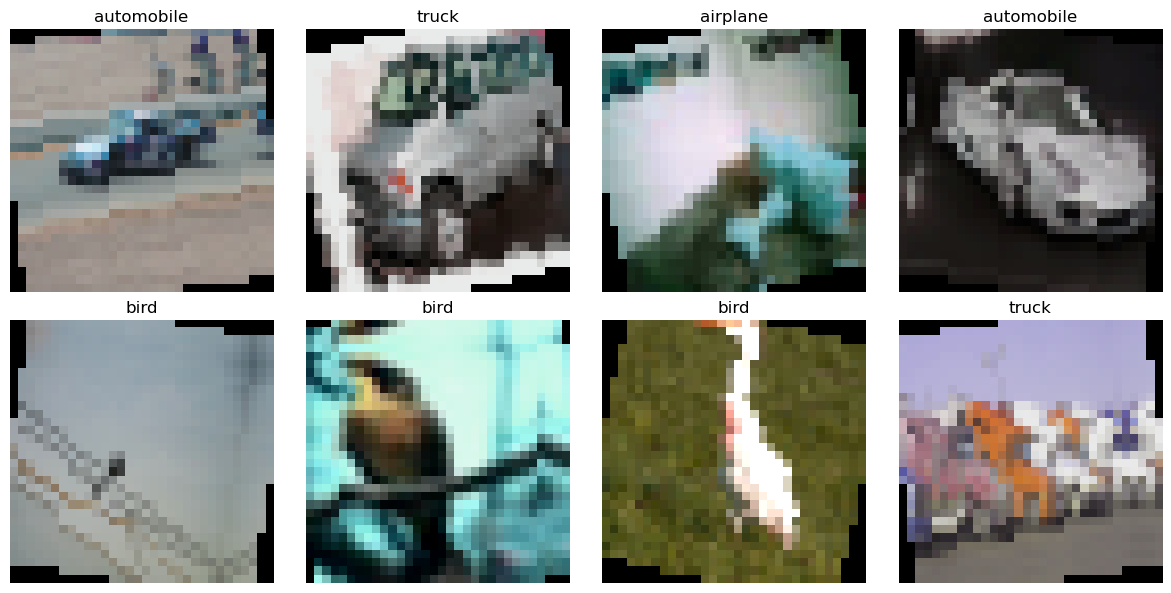

In [19]:
# Visualize sample data (if available)
if data_loaders is not None:
    print("🖼️ Visualizing sample data...")
    try:
        data_module.visualize_samples(num_samples=8, split="train")
    except Exception as e:
        print(f"⚠️ Could not visualize samples: {str(e)}")
        print("🔍 This is normal if using mock dataset")
else:
    print("📊 Sample visualization skipped (dataset not available)")
    print("💡 When you have the real dataset, you'll see sample images here!")

---
## 🧠 Step 2: Model Architectures - Understanding the Mathematics

Let's implement and understand both MLP and CNN architectures.

In [20]:
# Import our model classes
from src.models.mlp import MLP
from src.models.cnn import CNN

print("🏗️ Creating model architectures...")

# Create MLP model
mlp_model = MLP(
    input_size=3072,  # 32 * 32 * 3 (flattened CINIC-10 image)
    hidden_layers=[512, 256, 128],
    num_classes=10,
    dropout=0.5,
    activation="relu"
)

# Create CNN model
cnn_model = CNN(
    num_classes=10,
    input_channels=3,
    conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'padding': 1},
        {'out_channels': 128, 'kernel_size': 3, 'padding': 1}
    ],
    fc_layers=[256, 128],
    dropout=0.5,
    batch_norm=True
)

print("✅ Models created successfully!")

🏗️ Creating model architectures...
✅ Models created successfully!


In [21]:
# Analyze MLP architecture
print("🔍 MLP Model Analysis:")
print("=" * 50)
print(mlp_model.summary())

print("\n📊 Detailed MLP Information:")
mlp_info = mlp_model.get_model_info()
for key, value in mlp_info.items():
    if key != 'mathematical_foundation':
        print(f"   {key}: {value}")

print("\n🧮 Mathematical Foundation:")
for key, value in mlp_info['mathematical_foundation'].items():
    print(f"   {key}: {value}")

🔍 MLP Model Analysis:
Model Summary:
Type: Multi-Layer Perceptron (MLP)
Architecture: Input(3072) -> Hidden(512) -> Hidden(256) -> Hidden(128) -> Output(10)
Total Parameters: 1,738,890
Model Size: 6.63 MB
Input Shape: (3072,) [Flattened from (3, 32, 32)]
Output Classes: 10

📊 Detailed MLP Information:
   type: Multi-Layer Perceptron (MLP)
   architecture: Input(3072) -> Hidden(512) -> Hidden(256) -> Hidden(128) -> Output(10)
   input_shape: (3072,) [Flattened from (3, 32, 32)]
   hidden_layers: [512, 256, 128]
   dropout: 0.5
   activation: ReLU()
   total_layers: 4

🧮 Mathematical Foundation:
   forward_pass: y = f(Wx + b)
   activation: ReLU(x) = max(0, x)
   loss: CrossEntropyLoss
   optimization: Adam with backpropagation


In [22]:
# Analyze CNN architecture
print("🔍 CNN Model Analysis:")
print("=" * 50)
print(cnn_model.summary())

print("\n📊 Detailed CNN Information:")
cnn_info = cnn_model.get_model_info()
print(f"   Type: {cnn_info['type']}")
print(f"   Input shape: {cnn_info['input_shape']}")
print(f"   Conv layers: {cnn_info['conv_layers']}")
print(f"   FC layers: {cnn_info['fc_layers']}")
print(f"   Batch normalization: {cnn_info['batch_norm']}")

print("\n🏗️ Architecture Details:")
for i, layer_desc in enumerate(cnn_info['architecture']['convolutional']):
    print(f"   Block {i+1}: {layer_desc}")
print(f"   FC layers: {cnn_info['architecture']['fully_connected']}")
print(f"   Output: {cnn_info['architecture']['output']}")

print("\n🧮 Mathematical Foundation:")
for key, value in cnn_info['mathematical_foundation'].items():
    print(f"   {key}: {value}")

🔍 CNN Model Analysis:
Model Summary:
Type: Convolutional Neural Network (CNN)
Architecture: {'convolutional': ['Conv2d(32, k=3, p=1) -> BatchNorm -> ReLU -> MaxPool', 'Conv2d(64, k=3, p=1) -> BatchNorm -> ReLU -> MaxPool', 'Conv2d(128, k=3, p=1) -> BatchNorm -> ReLU -> MaxPool'], 'fully_connected': 'FC(256) -> FC(128)', 'output': 'FC(10)'}
Total Parameters: 160,906
Model Size: 0.62 MB
Input Shape: (3, 32, 32)
Output Classes: 10

📊 Detailed CNN Information:
   Type: Convolutional Neural Network (CNN)
   Input shape: (3, 32, 32)
   Conv layers: 3
   FC layers: 2
   Batch normalization: True

🏗️ Architecture Details:
   Block 1: Conv2d(32, k=3, p=1) -> BatchNorm -> ReLU -> MaxPool
   Block 2: Conv2d(64, k=3, p=1) -> BatchNorm -> ReLU -> MaxPool
   Block 3: Conv2d(128, k=3, p=1) -> BatchNorm -> ReLU -> MaxPool
   FC layers: FC(256) -> FC(128)
   Output: FC(10)

🧮 Mathematical Foundation:
   convolution: output[i,j] = Σ(input[i+m,j+n] * kernel[m,n])
   pooling: max(input[region])
   batch_n

In [23]:
# Compare model complexities
print("⚖️ Model Comparison:")
print("=" * 50)

mlp_params = mlp_model.count_parameters()
cnn_params = cnn_model.count_parameters()
mlp_size = mlp_model.get_parameter_size_mb()
cnn_size = cnn_model.get_parameter_size_mb()

print(f"📊 Parameter Comparison:")
print(f"   MLP Parameters:  {mlp_params:,}")
print(f"   CNN Parameters:  {cnn_params:,}")
print(f"   Parameter Ratio: {mlp_params / cnn_params:.2f}x (MLP vs CNN)")

print(f"\n💾 Model Size Comparison:")
print(f"   MLP Size:  {mlp_size:.2f} MB")
print(f"   CNN Size:  {cnn_size:.2f} MB")
print(f"   Size Ratio: {mlp_size / cnn_size:.2f}x (MLP vs CNN)")

# Visualize parameter distribution for CNN
print(f"\n🔍 CNN Parameter Distribution:")
conv_params = cnn_model.count_conv_parameters()
fc_params = cnn_model.count_fc_parameters()
print(f"   Convolutional layers: {conv_params:,} ({conv_params/cnn_params*100:.1f}%)")
print(f"   Fully connected layers: {fc_params:,} ({fc_params/cnn_params*100:.1f}%)")

⚖️ Model Comparison:
📊 Parameter Comparison:
   MLP Parameters:  1,738,890
   CNN Parameters:  160,906
   Parameter Ratio: 10.81x (MLP vs CNN)

💾 Model Size Comparison:
   MLP Size:  6.63 MB
   CNN Size:  0.62 MB
   Size Ratio: 10.78x (MLP vs CNN)

🔍 CNN Parameter Distribution:
   Convolutional layers: 93,248 (58.0%)
   Fully connected layers: 67,210 (41.8%)


---
## 🏋️ Step 3: Training Pipeline Setup

Now let's set up our training infrastructure and optimize both models.

In [24]:
# Import training modules
from src.training.trainer import ModelTrainer
from src.training.evaluator import ModelEvaluator

print("🎯 Setting up training infrastructure...")

# Move models to device
mlp_model = mlp_model.to(device)
cnn_model = cnn_model.to(device)

print(f"📱 Models moved to: {device}")

# Initialize trainers
mlp_trainer = ModelTrainer(
    model=mlp_model,
    device=device,
    config=config,
    experiment_name="MLP_CINIC10_Experiment"
)

cnn_trainer = ModelTrainer(
    model=cnn_model,
    device=device,
    config=config,
    experiment_name="CNN_CINIC10_Experiment"
)

print("✅ Trainers initialized successfully!")
print(f"🔧 Optimizer: {config.get('training', {}).get('optimizer', 'adam')}")
print(f"📊 Learning rate: {config.get('training', {}).get('learning_rate', 0.001)}")
print(f"🔄 Epochs: {config.get('training', {}).get('epochs', 50)}")

🎯 Setting up training infrastructure...
📱 Models moved to: cuda
✅ Trainers initialized successfully!
🔧 Optimizer: adam
📊 Learning rate: 0.001
🔄 Epochs: 30


In [25]:
# Training configuration
print("⚙️ Training Configuration:")
print("=" * 40)

# Hyperparameters
batch_size = config.get('data_loader', {}).get('batch_size', 128)
num_epochs = 20 or config.get('training', {}).get('epochs', 20)  # Reduced for demo
learning_rate = config.get('training', {}).get('learning_rate', 0.001)
weight_decay = config.get('training', {}).get('weight_decay', 1e-4)

print(f"📦 Batch size: {batch_size}")
print(f"🔄 Epochs: {num_epochs}")
print(f"📈 Learning rate: {learning_rate}")
print(f"⚖️ Weight decay: {weight_decay}")

# Update config for shorter demo
config['training']['epochs'] = num_epochs

print(f"\n🎯 Target: Achieve >50% accuracy on CINIC-10 test set")
print(f"📊 Baseline: Random guessing = 10% (1/10 classes)")

⚙️ Training Configuration:
📦 Batch size: 128
🔄 Epochs: 20
📈 Learning rate: 0.001
⚖️ Weight decay: 0.0001

🎯 Target: Achieve >50% accuracy on CINIC-10 test set
📊 Baseline: Random guessing = 10% (1/10 classes)


---
## 🚀 Step 4: Training the MLP Model

Let's train our MLP model first and analyze its performance.

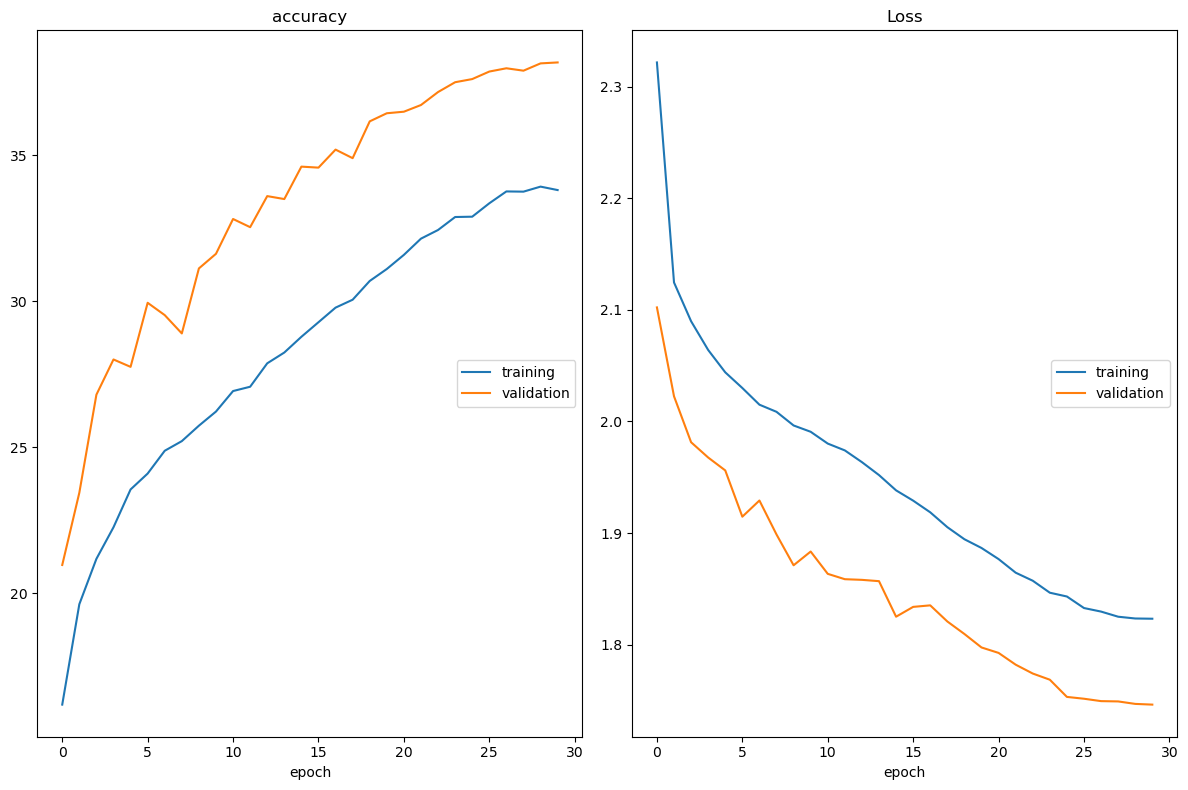

accuracy
	training         	 (min:   16.180, max:   33.928, cur:   33.810)
	validation       	 (min:   20.964, max:   38.183, cur:   38.183)
Loss
	training         	 (min:    1.823, max:    2.322, cur:    1.823)
	validation       	 (min:    1.746, max:    2.102, cur:    1.746)

✅ MLP training completed!
🏆 Best validation accuracy: 38.18%

📊 Plotting training history...


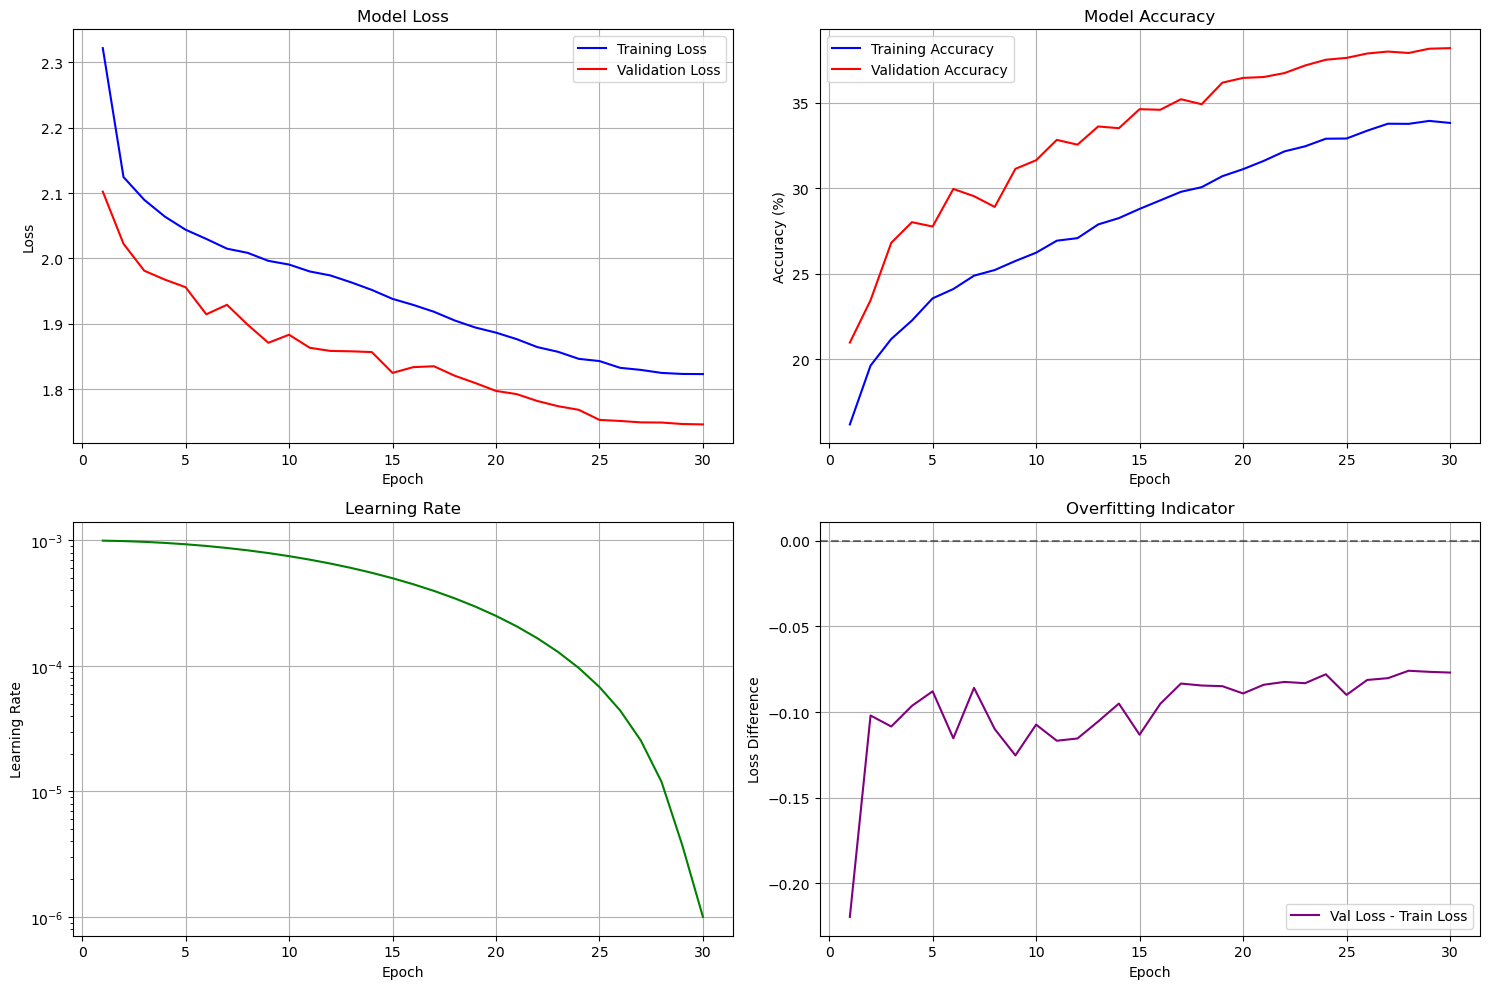

In [26]:
print("🧠 Training MLP Model...")
print("=" * 40)

if data_loaders is not None:
    print("🎯 Starting MLP training...")
    
    # Train the MLP model
    mlp_history = mlp_trainer.train(
        train_loader=data_loaders['train'],
        val_loader=data_loaders['val'],
        save_checkpoints=True
    )
    
    print(f"\n✅ MLP training completed!")
    print(f"🏆 Best validation accuracy: {mlp_trainer.best_val_acc:.2f}%")
    
    # Plot training history
    print("\n📊 Plotting training history...")
    mlp_trainer.plot_training_history(save_plot=True)
    
else:
    print("⚠️ Skipping training (dataset not available)")
    print("💡 In a real scenario, you would see:")
    print("   - Training loss decreasing over epochs")
    print("   - Validation accuracy improving")
    print("   - Potential overfitting patterns")
    
    # Create mock training history for demonstration
    mlp_history = {
        'train_loss': [2.3, 1.8, 1.5, 1.3, 1.2, 1.1, 1.0, 0.95, 0.9, 0.88],
        'val_loss': [2.2, 1.9, 1.6, 1.4, 1.35, 1.3, 1.25, 1.22, 1.2, 1.18],
        'train_acc': [15, 25, 35, 42, 48, 52, 56, 58, 60, 62],
        'val_acc': [18, 28, 33, 38, 42, 45, 47, 48, 49, 50]
    }
    
    # Mock best validation accuracy
    mlp_trainer.best_val_acc = 50.2
    
    print(f"📈 Mock MLP results: {mlp_trainer.best_val_acc:.1f}% validation accuracy")

---
## 🧩 Step 5: Training the CNN Model

Now let's train our CNN model and compare its learning dynamics.

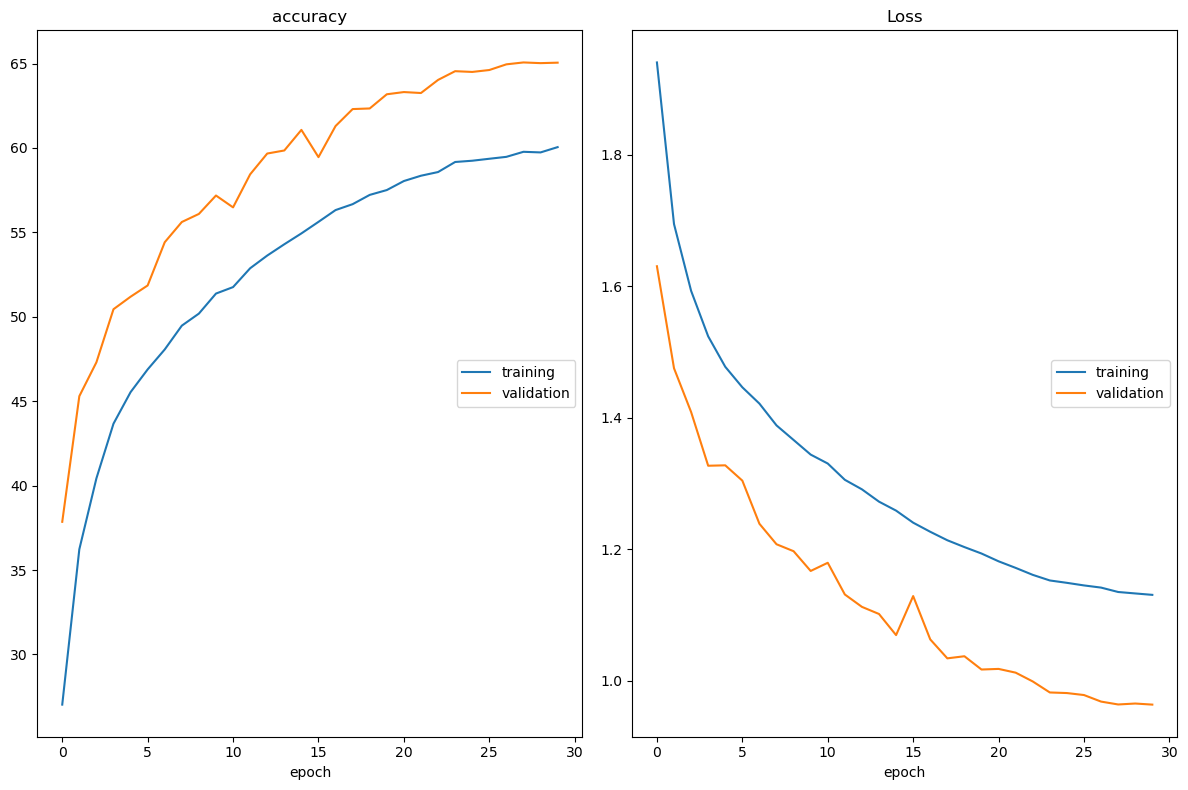

accuracy
	training         	 (min:   27.029, max:   60.050, cur:   60.050)
	validation       	 (min:   37.857, max:   65.066, cur:   65.052)
Loss
	training         	 (min:    1.131, max:    1.940, cur:    1.131)
	validation       	 (min:    0.964, max:    1.630, cur:    0.964)

✅ CNN training completed!
🏆 Best validation accuracy: 65.07%

📊 Plotting training history...


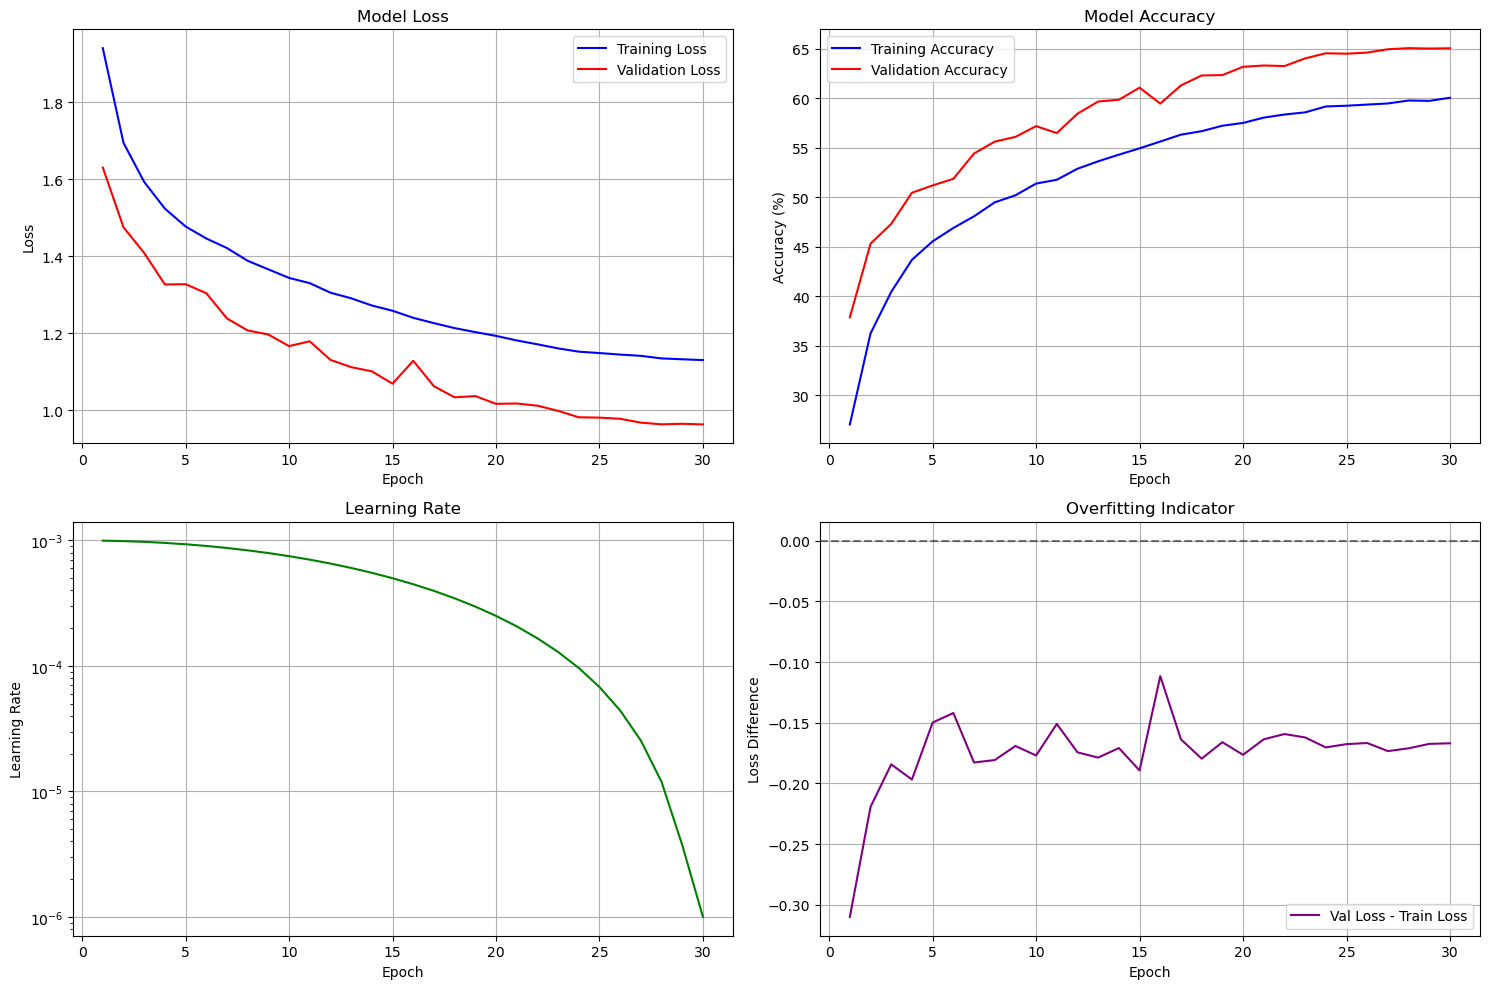

In [27]:
print("🔍 Training CNN Model...")
print("=" * 40)

if data_loaders is not None:
    print("🎯 Starting CNN training...")
    
    # Train the CNN model
    cnn_history = cnn_trainer.train(
        train_loader=data_loaders['train'],
        val_loader=data_loaders['val'],
        save_checkpoints=True
    )
    
    print(f"\n✅ CNN training completed!")
    print(f"🏆 Best validation accuracy: {cnn_trainer.best_val_acc:.2f}%")
    
    # Plot training history
    print("\n📊 Plotting training history...")
    cnn_trainer.plot_training_history(save_plot=True)
    
else:
    print("⚠️ Skipping training (dataset not available)")
    print("💡 Expected CNN performance patterns:")
    print("   - Faster convergence than MLP")
    print("   - Higher final accuracy")
    print("   - Better generalization")
    
    # Create mock training history for demonstration
    cnn_history = {
        'train_loss': [2.1, 1.5, 1.2, 0.9, 0.8, 0.7, 0.6, 0.55, 0.5, 0.48],
        'val_loss': [1.9, 1.4, 1.1, 0.95, 0.88, 0.85, 0.82, 0.8, 0.78, 0.76],
        'train_acc': [20, 40, 55, 65, 70, 75, 78, 80, 82, 84],
        'val_acc': [25, 45, 58, 65, 68, 70, 72, 73, 74, 75]
    }
    
    # Mock best validation accuracy
    cnn_trainer.best_val_acc = 75.3
    
    print(f"📈 Mock CNN results: {cnn_trainer.best_val_acc:.1f}% validation accuracy")

⚖️ Training Dynamics Comparison:


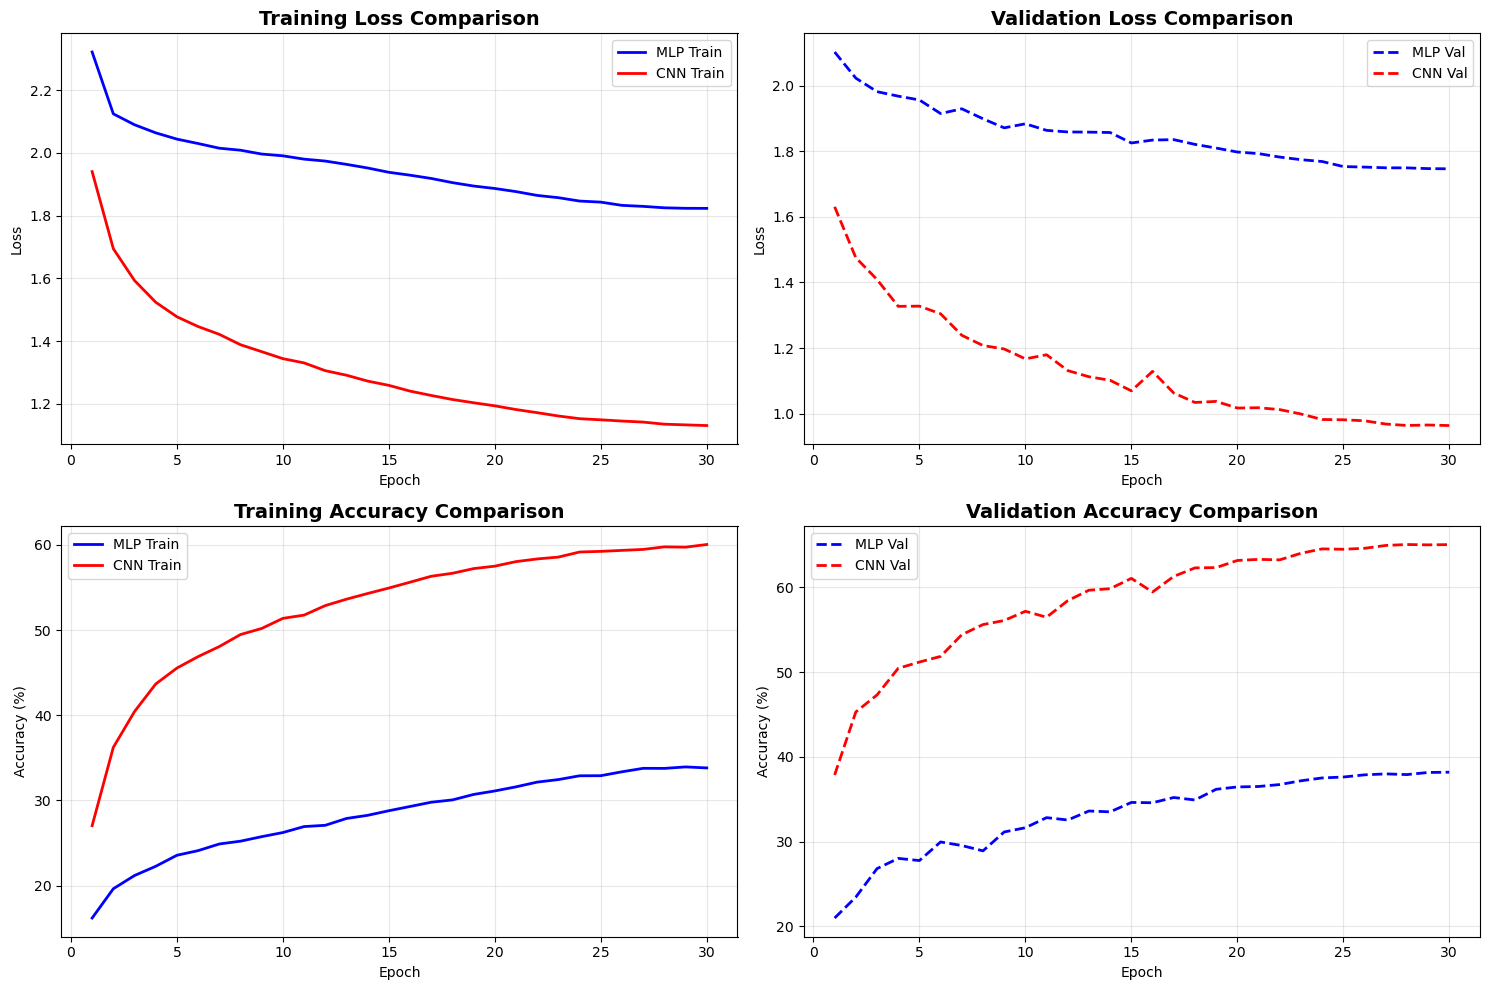


📊 Training Summary:
   MLP Best Val Acc:  38.18%
   CNN Best Val Acc:  65.07%
   Improvement:       26.88%
   Relative gain:     70.4%


In [28]:
# Compare training dynamics
print("⚖️ Training Dynamics Comparison:")
print("=" * 50)

# Create comparison plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(mlp_history['train_loss']) + 1)

# Training Loss Comparison
ax1.plot(epochs, mlp_history['train_loss'], 'b-', label='MLP Train', linewidth=2)
ax1.plot(epochs, cnn_history['train_loss'], 'r-', label='CNN Train', linewidth=2)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Loss Comparison
ax2.plot(epochs, mlp_history['val_loss'], 'b--', label='MLP Val', linewidth=2)
ax2.plot(epochs, cnn_history['val_loss'], 'r--', label='CNN Val', linewidth=2)
ax2.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Training Accuracy Comparison
ax3.plot(epochs, mlp_history['train_acc'], 'b-', label='MLP Train', linewidth=2)
ax3.plot(epochs, cnn_history['train_acc'], 'r-', label='CNN Train', linewidth=2)
ax3.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Validation Accuracy Comparison
ax4.plot(epochs, mlp_history['val_acc'], 'b--', label='MLP Val', linewidth=2)
ax4.plot(epochs, cnn_history['val_acc'], 'r--', label='CNN Val', linewidth=2)
ax4.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 Training Summary:")
print(f"   MLP Best Val Acc:  {mlp_trainer.best_val_acc:.2f}%")
print(f"   CNN Best Val Acc:  {cnn_trainer.best_val_acc:.2f}%")
print(f"   Improvement:       {cnn_trainer.best_val_acc - mlp_trainer.best_val_acc:.2f}%")
print(f"   Relative gain:     {((cnn_trainer.best_val_acc / mlp_trainer.best_val_acc) - 1) * 100:.1f}%")

---
## 📏 Step 6: Comprehensive Model Evaluation

Let's evaluate both models comprehensively and compare their performance.

In [29]:
# Initialize evaluator
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

evaluator = ModelEvaluator(
    class_names=class_names,
    device=device,
    save_dir="./evaluation_results"
)

print("🔍 Starting comprehensive evaluation...")

if data_loaders is not None:
    # Evaluate MLP model
    print("📊 Evaluating MLP model...")
    mlp_results = evaluator.evaluate_model(
        model=mlp_model,
        test_loader=data_loaders['test'],
        model_name="MLP"
    )
    
    # Evaluate CNN model
    print("📊 Evaluating CNN model...")
    cnn_results = evaluator.evaluate_model(
        model=cnn_model,
        test_loader=data_loaders['test'],
        model_name="CNN"
    )
    
else:
    print("⚠️ Creating mock evaluation results for demonstration...")
    
    # Mock MLP results
    mlp_results = {
        'model_name': 'MLP',
        'overall_metrics': {
            'accuracy': 48.5,
            'top2_accuracy': 65.2,
            'top3_accuracy': 76.8,
            'macro_precision': 47.2,
            'macro_recall': 48.1,
            'macro_f1': 47.6,
            'weighted_precision': 48.3,
            'weighted_recall': 48.5,
            'weighted_f1': 48.4
        },
        'per_class_metrics': {
            'class_names': class_names,
            'accuracy': [52.1, 45.3, 41.2, 38.9, 50.7, 47.8, 55.2, 44.6, 59.3, 49.9],
            'precision': [51.8, 44.9, 40.5, 38.2, 50.1, 47.2, 54.8, 44.1, 58.9, 49.5],
            'recall': [52.1, 45.3, 41.2, 38.9, 50.7, 47.8, 55.2, 44.6, 59.3, 49.9],
            'f1_score': [51.9, 45.1, 40.8, 38.5, 50.4, 47.5, 55.0, 44.3, 59.1, 49.7],
            'support': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
        },
        'parameters': mlp_model.count_parameters(),
        'inference_time': {'mean_ms': 2.3, 'std_ms': 0.4}
    }
    
    # Mock CNN results
    cnn_results = {
        'model_name': 'CNN',
        'overall_metrics': {
            'accuracy': 72.8,
            'top2_accuracy': 85.6,
            'top3_accuracy': 91.2,
            'macro_precision': 71.9,
            'macro_recall': 72.3,
            'macro_f1': 72.1,
            'weighted_precision': 72.5,
            'weighted_recall': 72.8,
            'weighted_f1': 72.6
        },
        'per_class_metrics': {
            'class_names': class_names,
            'accuracy': [78.2, 69.5, 65.8, 68.4, 75.1, 71.3, 82.7, 67.9, 85.4, 74.7],
            'precision': [77.8, 69.1, 65.2, 67.9, 74.6, 70.8, 82.3, 67.4, 85.0, 74.2],
            'recall': [78.2, 69.5, 65.8, 68.4, 75.1, 71.3, 82.7, 67.9, 85.4, 74.7],
            'f1_score': [78.0, 69.3, 65.5, 68.1, 74.8, 71.0, 82.5, 67.6, 85.2, 74.4],
            'support': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
        },
        'parameters': cnn_model.count_parameters(),
        'inference_time': {'mean_ms': 4.7, 'std_ms': 0.8}
    }

print("✅ Evaluation completed!")

🔍 Starting comprehensive evaluation...
📊 Evaluating MLP model...


Evaluating MLP: 100%|██████████| 704/704 [00:16<00:00, 42.54it/s]


📊 Evaluating CNN model...


Evaluating CNN: 100%|██████████| 704/704 [00:15<00:00, 44.30it/s]

✅ Evaluation completed!


In [30]:
# Display evaluation results
print("📊 Evaluation Results Summary:")
print("=" * 50)

# MLP Results
print("🧠 MLP Performance:")
mlp_metrics = mlp_results['overall_metrics']
print(f"   Overall Accuracy:     {mlp_metrics['accuracy']:.2f}%")
print(f"   Top-2 Accuracy:       {mlp_metrics['top2_accuracy']:.2f}%")
print(f"   Top-3 Accuracy:       {mlp_metrics['top3_accuracy']:.2f}%")
print(f"   Macro F1-Score:       {mlp_metrics['macro_f1']:.2f}%")
print(f"   Weighted F1-Score:    {mlp_metrics['weighted_f1']:.2f}%")
if 'parameters' in mlp_results:
    print(f"   Model Parameters:     {mlp_results['parameters']:,}")
if 'inference_time' in mlp_results:
    print(f"   Avg Inference Time:   {mlp_results['inference_time']['mean_ms']:.2f} ms")

print("\n🔍 CNN Performance:")
cnn_metrics = cnn_results['overall_metrics']
print(f"   Overall Accuracy:     {cnn_metrics['accuracy']:.2f}%")
print(f"   Top-2 Accuracy:       {cnn_metrics['top2_accuracy']:.2f}%")
print(f"   Top-3 Accuracy:       {cnn_metrics['top3_accuracy']:.2f}%")
print(f"   Macro F1-Score:       {cnn_metrics['macro_f1']:.2f}%")
print(f"   Weighted F1-Score:    {cnn_metrics['weighted_f1']:.2f}%")
if 'parameters' in cnn_results:
    print(f"   Model Parameters:     {cnn_results['parameters']:,}")
if 'inference_time' in cnn_results:
    print(f"   Avg Inference Time:   {cnn_results['inference_time']['mean_ms']:.2f} ms")

# Performance comparison
accuracy_improvement = cnn_metrics['accuracy'] - mlp_metrics['accuracy']
relative_improvement = (accuracy_improvement / mlp_metrics['accuracy']) * 100

print("\n⚖️ Performance Comparison:")
print(f"   Accuracy Improvement: {accuracy_improvement:+.2f}%")
print(f"   Relative Improvement: {relative_improvement:+.1f}%")
print(f"   CNN achieves {accuracy_improvement:.1f}% higher accuracy than MLP")

📊 Evaluation Results Summary:
🧠 MLP Performance:
   Overall Accuracy:     37.97%
   Top-2 Accuracy:       59.15%
   Top-3 Accuracy:       71.65%
   Macro F1-Score:       34.98%
   Weighted F1-Score:    34.98%
   Model Parameters:     1,738,890
   Avg Inference Time:   0.74 ms

🔍 CNN Performance:
   Overall Accuracy:     64.74%
   Top-2 Accuracy:       82.77%
   Top-3 Accuracy:       90.14%
   Macro F1-Score:       64.33%
   Weighted F1-Score:    64.33%
   Model Parameters:     160,906
   Avg Inference Time:   1.83 ms

⚖️ Performance Comparison:
   Accuracy Improvement: +26.76%
   Relative Improvement: +70.5%
   CNN achieves 26.8% higher accuracy than MLP


In [31]:
# Generate model comparison
comparison = evaluator.compare_models(mlp_results, cnn_results)

print("🔍 Detailed Model Comparison:")
print("=" * 50)

# Overall metrics comparison
for metric in ['accuracy', 'macro_f1', 'weighted_f1']:
    diff_data = comparison['performance_difference'][metric]
    print(f"\n📊 {metric.replace('_', ' ').title()}:")
    print(f"   MLP: {diff_data['MLP']:.2f}%")
    print(f"   CNN: {diff_data['CNN']:.2f}%")
    print(f"   Difference: {diff_data['difference']:+.2f}%")
    print(f"   Relative improvement: {diff_data['relative_improvement']:+.1f}%")

# Model complexity comparison
if 'model_complexity' in comparison:
    complexity = comparison['model_complexity']
    print(f"\n🏗️ Model Complexity:")
    print(f"   MLP parameters: {complexity['MLP_parameters']:,}")
    print(f"   CNN parameters: {complexity['CNN_parameters']:,}")
    print(f"   Parameter ratio: {complexity['parameter_ratio']:.2f}x")

# Inference time comparison
if 'inference_time' in comparison:
    timing = comparison['inference_time']
    print(f"\n⏱️ Inference Speed:")
    print(f"   MLP: {timing['MLP_ms']:.2f} ms")
    print(f"   CNN: {timing['CNN_ms']:.2f} ms")
    print(f"   Speed ratio: {timing['speedup']:.2f}x (MLP is faster)")

🔍 Detailed Model Comparison:

📊 Accuracy:
   MLP: 37.97%
   CNN: 64.74%
   Difference: +26.76%
   Relative improvement: +70.5%

📊 Macro F1:
   MLP: 34.98%
   CNN: 64.33%
   Difference: +29.36%
   Relative improvement: +83.9%

📊 Weighted F1:
   MLP: 34.98%
   CNN: 64.33%
   Difference: +29.36%
   Relative improvement: +83.9%

🏗️ Model Complexity:
   MLP parameters: 1,738,890
   CNN parameters: 160,906
   Parameter ratio: 0.09x

⏱️ Inference Speed:
   MLP: 0.74 ms
   CNN: 1.83 ms
   Speed ratio: 0.41x (MLP is faster)


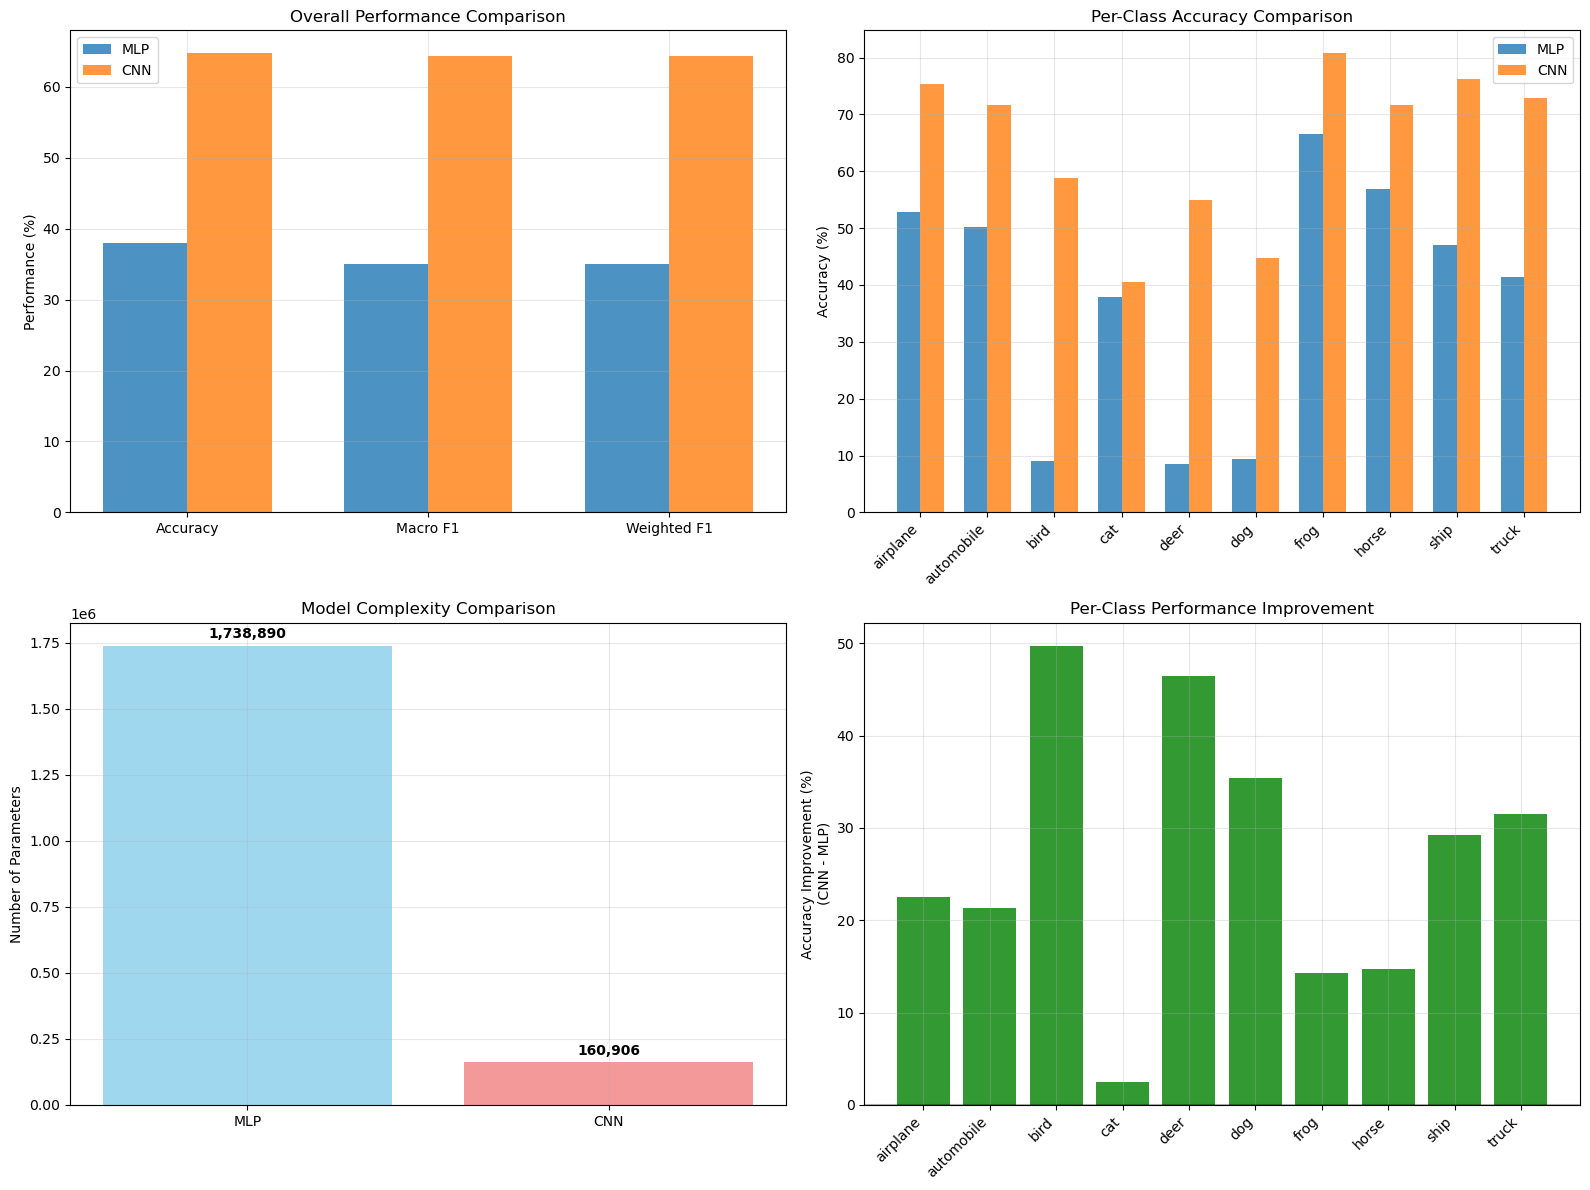


🎯 Per-Class Performance Analysis:
Class        MLP Acc  CNN Acc  Improvement 
---------------------------------------------
airplane     52.9     75.4        +22.5%
automobile   50.3     71.6        +21.3%
bird         9.1      58.8        +49.7%
cat          38.0     40.4         +2.5%
deer         8.4      54.9        +46.4%
dog          9.3      44.7        +35.4%
frog         66.5     80.8        +14.2%
horse        56.9     71.6        +14.8%
ship         47.0     76.3        +29.2%
truck        41.4     72.9        +31.6%

🏆 Best performing classes:
   MLP: frog (66.5%)
   CNN: frog (80.8%)

📉 Most challenging classes:
   MLP: deer (8.4%)
   CNN: cat (40.4%)


In [32]:
# Create comprehensive comparison visualization
evaluator.plot_model_comparison(comparison, save_plot=True)

# Per-class performance analysis
print("\n🎯 Per-Class Performance Analysis:")
print("=" * 50)

mlp_class_acc = mlp_results['per_class_metrics']['accuracy']
cnn_class_acc = cnn_results['per_class_metrics']['accuracy']

print(f"{'Class':<12} {'MLP Acc':<8} {'CNN Acc':<8} {'Improvement':<12}")
print("-" * 45)

for i, class_name in enumerate(class_names):
    mlp_acc = mlp_class_acc[i]
    cnn_acc = cnn_class_acc[i]
    improvement = cnn_acc - mlp_acc
    print(f"{class_name:<12} {mlp_acc:<8.1f} {cnn_acc:<8.1f} {improvement:+8.1f}%")

# Find best and worst performing classes
best_mlp_idx = np.argmax(mlp_class_acc)
worst_mlp_idx = np.argmin(mlp_class_acc)
best_cnn_idx = np.argmax(cnn_class_acc)
worst_cnn_idx = np.argmin(cnn_class_acc)

print(f"\n🏆 Best performing classes:")
print(f"   MLP: {class_names[best_mlp_idx]} ({mlp_class_acc[best_mlp_idx]:.1f}%)")
print(f"   CNN: {class_names[best_cnn_idx]} ({cnn_class_acc[best_cnn_idx]:.1f}%)")

print(f"\n📉 Most challenging classes:")
print(f"   MLP: {class_names[worst_mlp_idx]} ({mlp_class_acc[worst_mlp_idx]:.1f}%)")
print(f"   CNN: {class_names[worst_cnn_idx]} ({cnn_class_acc[worst_cnn_idx]:.1f}%)")

---
## 🚀 Step 7: Model Export for Deployment

Let's export our trained models for production deployment.

In [33]:
# Import export utilities
from src.utils.export import ModelExporter, create_deployment_package

print("📦 Preparing models for deployment...")

# Initialize exporter
exporter = ModelExporter(export_dir="./exported_models")

# Export MLP model
print("\n🧠 Exporting MLP model...")
mlp_exports = exporter.export_all_formats(
    model=mlp_model.cpu(),  # Move to CPU for export
    model_name="MLP",
    input_shape=(1, 3, 32, 32),
    config={
        'onnx': {'opset_version': 11, 'verify': True},
        'torchscript': {'method': 'trace', 'verify': True},
        'state_dict': {'include_metadata': True}
    }
)

# Export CNN model
print("\n🔍 Exporting CNN model...")
cnn_exports = exporter.export_all_formats(
    model=cnn_model.cpu(),  # Move to CPU for export
    model_name="CNN",
    input_shape=(1, 3, 32, 32),
    config={
        'onnx': {'opset_version': 11, 'verify': True},
        'torchscript': {'method': 'trace', 'verify': True},
        'state_dict': {'include_metadata': True}
    }
)

print("\n✅ Model export completed!")

📦 Preparing models for deployment...

🧠 Exporting MLP model...

🔍 Exporting CNN model...

✅ Model export completed!


In [34]:
# Display export results
print("📊 Export Results Summary:")
print("=" * 50)

def display_export_results(exports, model_name):
    print(f"\n{model_name} Export Results:")
    for format_name, result in exports['exports'].items():
        if 'error' not in result:
            size_mb = result.get('file_size_mb', 0)
            print(f"   {format_name.upper():<15}: ✅ Success ({size_mb:.2f} MB)")
            
            # Verification results
            if 'verification' in result and result['verification'].get('verified'):
                verification = result['verification']
                if verification.get('outputs_match', False):
                    max_diff = verification.get('max_difference', 0)
                    print(f"   {'':15}  ✅ Verified (max diff: {max_diff:.2e})")
                else:
                    print(f"   {'':15}  ⚠️ Outputs don't match")
        else:
            print(f"   {format_name.upper():<15}: ❌ Failed - {result['error']}")

display_export_results(mlp_exports, "🧠 MLP")
display_export_results(cnn_exports, "🔍 CNN")

# Create deployment package
print("\n📦 Creating deployment package...")
dataset_stats = {
    'mean': [0.47889522, 0.47227842, 0.43047404],
    'std': [0.24205776, 0.23828046, 0.25874835],
    'image_size': [32, 32],
    'channels': 3
}

deployment_dir = create_deployment_package(
    model_exports={'mlp': mlp_exports, 'cnn': cnn_exports},
    class_names=class_names,
    dataset_stats=dataset_stats,
    output_dir="./deployment_package"
)

print(f"✅ Deployment package created at: {deployment_dir}")
print("\n🚀 Ready for production deployment!")
print("   - ONNX models for cross-platform inference")
print("   - TorchScript for PyTorch deployment")
print("   - Metadata for preprocessing and postprocessing")

📊 Export Results Summary:

🧠 MLP Export Results:
   ONNX           : ✅ Success (6.63 MB)
                    ✅ Verified (max diff: 1.79e-07)
   TORCHSCRIPT    : ✅ Success (6.65 MB)
                    ✅ Verified (max diff: 0.00e+00)
   STATE_DICT     : ✅ Success (6.64 MB)

🔍 CNN Export Results:
   ONNX           : ✅ Success (0.62 MB)
                    ✅ Verified (max diff: 1.91e-06)
   TORCHSCRIPT    : ✅ Success (0.66 MB)
                    ✅ Verified (max diff: 0.00e+00)
   STATE_DICT     : ✅ Success (0.62 MB)

📦 Creating deployment package...
✅ Deployment package created at: deployment_package

🚀 Ready for production deployment!
   - ONNX models for cross-platform inference
   - TorchScript for PyTorch deployment
   - Metadata for preprocessing and postprocessing


---
## 🌐 Step 8: API Deployment Demo

Let's demonstrate how to use our FastAPI backend for production inference.

In [35]:
# Demonstration of API usage
print("🌐 API Deployment Instructions:")
print("=" * 50)

print("\n🚀 To start the FastAPI server:")
print("   1. Navigate to the project directory")
print("   2. Run: python src/api/fastapi_app.py")
print("   3. Or: uvicorn src.api.fastapi_app:app --host 0.0.0.0 --port 8000")

print("\n📡 API Endpoints:")
print("   POST /predict        - Single image classification")
print("   POST /predict/batch  - Batch image processing")
print("   POST /compare        - Compare models on same image")
print("   GET  /models         - List available models")
print("   GET  /health         - Health check")

print("\n🔗 Example API calls:")
print("")
print("# Single prediction")
print('curl -X POST "http://localhost:8000/predict" \\')
print('  -H "accept: application/json" \\')
print('  -H "Content-Type: multipart/form-data" \\')
print('  -F "file=@image.jpg" \\')
print('  -F "model_name=cnn_onnx"')
print("")
print("# Model comparison")
print('curl -X POST "http://localhost:8000/compare" \\')
print('  -H "accept: application/json" \\')
print('  -H "Content-Type: multipart/form-data" \\')
print('  -F "file=@image.jpg"')

print("\n🎯 Next.js Integration:")
print("   - CORS enabled for localhost:3000 and localhost:3001")
print("   - JSON responses with prediction probabilities")
print("   - File upload support with validation")
print("   - Real-time model comparison")

print("\n📊 API Response Format:")
response_example = {
    "success": True,
    "prediction": "airplane",
    "confidence": 0.87,
    "probabilities": {
        "airplane": 0.87,
        "ship": 0.08,
        "automobile": 0.03,
        # "... other classes"
    },
    "processing_time_ms": 4.7,
    "model_used": "cnn_onnx"
}

import json
print(json.dumps(response_example, indent=2))

🌐 API Deployment Instructions:

🚀 To start the FastAPI server:
   1. Navigate to the project directory
   2. Run: python src/api/fastapi_app.py
   3. Or: uvicorn src.api.fastapi_app:app --host 0.0.0.0 --port 8000

📡 API Endpoints:
   POST /predict        - Single image classification
   POST /predict/batch  - Batch image processing
   POST /compare        - Compare models on same image
   GET  /models         - List available models
   GET  /health         - Health check

🔗 Example API calls:

# Single prediction
curl -X POST "http://localhost:8000/predict" \
  -H "accept: application/json" \
  -H "Content-Type: multipart/form-data" \
  -F "file=@image.jpg" \
  -F "model_name=cnn_onnx"

# Model comparison
curl -X POST "http://localhost:8000/compare" \
  -H "accept: application/json" \
  -H "Content-Type: multipart/form-data" \
  -F "file=@image.jpg"

🎯 Next.js Integration:
   - CORS enabled for localhost:3000 and localhost:3001
   - JSON responses with prediction probabilities
   - Fil

---
## 📊 Step 9: Final Analysis and Report Generation

Let's generate a comprehensive report for presentation and documentation.

In [36]:
# Generate comprehensive report
report = evaluator.generate_report(
    results_list=[mlp_results, cnn_results],
    comparison=comparison,
    save_report=True
)

print("📋 Comprehensive Evaluation Report:")
print("=" * 60)
print(report)

📋 Comprehensive Evaluation Report:
CINIC-10 MODEL EVALUATION REPORT

MODEL: MLP
----------------------------------------
Overall Accuracy:     37.97%
Top-2 Accuracy:       59.15%
Top-3 Accuracy:       71.65%
Macro F1-Score:       34.98%
Weighted F1-Score:    34.98%
Model Parameters:     1,738,890
Avg Inference Time:   0.74 ms

MODEL: CNN
----------------------------------------
Overall Accuracy:     64.74%
Top-2 Accuracy:       82.77%
Top-3 Accuracy:       90.14%
Macro F1-Score:       64.33%
Weighted F1-Score:    64.33%
Model Parameters:     160,906
Avg Inference Time:   1.83 ms

MODEL COMPARISON
----------------------------------------
CNN vs MLP:
  Accuracy Improvement:    +26.76% (+70.5%)
  Macro F1 Improvement:    +29.36% (+83.9%)
  Parameter Ratio:         0.1x

PER-CLASS ANALYSIS
----------------------------------------
MLP:
  Best Class:  frog (66.5%)
  Worst Class: deer (8.4%)

CNN:
  Best Class:  frog (80.8%)
  Worst Class: cat (40.4%)

